# DA5401 Assignment-4 : GMM-Based Synthetic Sampling for Imbalanced Data

## Problem Statement

We are given a **highly imbalanced credit card transaction dataset** where a very small fraction of transactions are fraudulent. This dataset presents transactions that occurred in two days, where we have 492 frauds out of over 284000 transactions. It contains only numerical input variables which are the result of a PCA transformation.  

Our task is to implement a **Gaussian Mixture Model based synthetic data generation** pipeline to create a training set that allows a classifier to learn the nuances of the minority (fraudulent) class without overfitting or misclassifying ana analyze its impact on model performance.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

## Part A : Baseline Model and Data Analysis

### 1.Data Loading and Analysis

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

We can see that all the column values are floats(numerical) and there are **no null values.**

In [4]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We can see that , for all the columns except Time, Amount and Class , Mean is nearly 0 and Standard Deviation is also very low , meaning that these features are already scaled.

### Class Distribution and Degree of Imbalance

In [5]:
class_dist = df['Class'].value_counts()
print("Class distribution:")
print(class_dist)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64


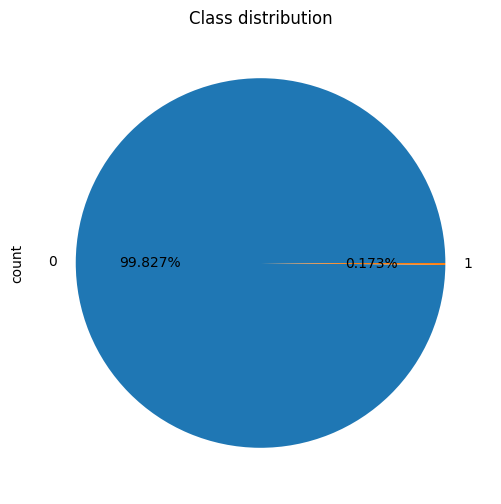

In [6]:
plt.figure(figsize = (6,6))
class_dist.plot.pie(autopct = '%1.3f%%', shadow = False)
plt.title("Class distribution")
plt.show()

**Degree of Imbalance** is the ratio of number of majority to number of minority samples. It is a way to quantify how skewed our dataset is between majority and minority classes.

In [7]:
degree_imbalance = class_dist.max() / class_dist.min()
print ("Degree Imbalance of this dataset is" , degree_imbalance)

Degree Imbalance of this dataset is 577.8760162601626


### 2.Baseline Model Training

#### Separating features and Target

In [8]:
X = df.drop('Class',axis = 1)
y = df['Class']

print (X.shape)

(284807, 30)


#### Scaling the Amount and Time columns

From the above data analysis , we can see that the columns Amount and Time are not scaled.

In [9]:
scaler = StandardScaler()
X["Amount"] = scaler.fit_transform(X[["Amount"]])
X["Time"] = scaler.fit_transform(X[["Time"]])

#### Dividing the dataset into train and test sets

Using the stratify keyword in train_test_split, we can ensure that the train and test sets retain their original imbalance

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print("Train distribution:", y_train.value_counts(normalize = True))
print("Test distribution:", y_test.value_counts(normalize = True))

Train distribution: Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test distribution: Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


#### Train Baseline model

In [11]:
model1 = LogisticRegression(max_iter = 200, random_state = 42)
model1.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


### 3.Evalute Model Performance

In [12]:
y_pred = model1.predict(X_test)

accuracy_baseline = accuracy_score(y_test, y_pred)
precision_baseline = precision_score(y_test, y_pred)
recall_baseline = recall_score(y_test, y_pred)
f1score_baseline = f1_score(y_test, y_pred)

print("Classification_report:\n")
print ("Accuracy:  ", accuracy_baseline)
print ("Precision:  ", precision_baseline)
print ("Recall:  ", recall_baseline)
print ("F1 score:  ", f1score_baseline)

Classification_report:

Accuracy:   0.9991573329588147
Precision:   0.8289473684210527
Recall:   0.6428571428571429
F1 score:   0.7241379310344828


In [13]:
print (confusion_matrix(y_test, y_pred))

[[56851    13]
 [   35    63]]


### Which metrics are good indicators of goodness of model

In classification problems involving highly imbalanced datasets, **overall accuracy is often a misleading performance metric**, as it primarily reflects the model’s ability to predict the majority class. For example, in a dataset where only 1% of the instances belong to the minority class, a model that always predicts the majority class would achieve 99% accuracy, yet completely fail to identify any minority cases.  

In such scenarios, metrics such as **Precision, Recall, and the F1-score provide more meaningful insights**. Precision measures the proportion of correctly predicted positive instances among all predicted positives, which is critical when false positives carry significant consequences. Recall, on the other hand, quantifies the proportion of actual positive cases that are correctly identified, making it especially important when missing positive instances is costly. The F1-score balances Precision and Recall, offering a single measure of performance that accounts for both false positives and false negatives. Together, these metrics focus on the minority class—the class of real interest in imbalanced problems—thereby providing a more reliable and informative evaluation of model effectiveness than accuracy alone.

## Part B : Gaussian Mixture Model for Synthetic Sampling

### 1. Theoretical Foundation

#### Difference between SMOTE and GMM-based Synthetic Sampling models

**SMOTE (Synthetic Minority Oversampling Technique)** generates synthetic samples by linearly interpolating between a minority data point and one of its nearest neighbors. This approach is relatively simple and efficient, but **it assumes that the minority class distribution is roughly uniform and continuous in the feature space**. As a result, SMOTE often **struggles when the minority data is clustered into sub-groups** or when the class boundary is highly nonlinear.  

In contrast, **GMM-based synthetic sampling** employs Gaussian Mixture Models to approximate the probability distribution of the minority class. Instead of relying on local interpolation, GMM **explicitly models the underlying data density as a mixture of Gaussian components**. New synthetic samples are then drawn from this probabilistic model, **ensuring that the generated data more faithfully reflects the true distribution of the minority class**.

Thus, while ***SMOTE is interpolation-based and local, GMM-based sampling is distribution-based and global.***

#### Why is GMM better for complex minority distributions

The advantage of GMM-based sampling lies in its ability to capture multimodality and complex shapes within the minority class distribution. In many real-world problems, the minority class is not a single homogeneous group but may consist of multiple clusters or sub-populations.  

SMOTE, by interpolating between nearest neighbors, can inadvertently generate synthetic points that fall in low-density or even majority-class regions, leading to noisy samples and class overlap. **GMM, on the other hand, learns the statistical structure of the minority class by fitting multiple Gaussian components, each representing a distinct sub-group**. This allows the model to respect cluster boundaries and produce synthetic samples that remain within high-density regions of the minority distribution.  

As a result, GMM-based synthetic sampling is theoretically better suited to handling minority classes with heterogeneous or complex feature space geometries, leading to higher-quality and more realistic synthetic data.

### 2. GMM Implementation

Divide the training data into majority and minority class datasets.

In [14]:
X_train_minority = X_train[y_train == 1]
X_train_majority = X_train[y_train == 0]
y_train_minority = y_train[y_train == 1]
y_train_majority = y_train[y_train == 0]

print (len(X_train_minority))

394


#### Choosing optimal value of k

In [15]:
k_range = range(1, 11)

aic_scores = []
bic_scores = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state = 42)
    gmm.fit(X_train_minority)
    
    aic_scores.append(gmm.aic(X_train_minority))
    bic_scores.append(gmm.bic(X_train_minority))

In [16]:
results = pd.DataFrame({
    "n_components": k_range,
    "AIC": aic_scores,
    "BIC": bic_scores
})

print(results)

   n_components           AIC           BIC
0             1  36138.687851  38106.981551
1             2  24855.562885  28796.126637
2             3  17948.643120  23861.476922
3             4  18511.688607  26396.792460
4             5  16434.042674  26291.416578
5             6  15313.213516  27142.857471
6             7  11620.532887  25422.446893
7             8  10607.135894  26381.319951
8             9   9407.805563  27154.259672
9            10   9279.968029  28998.692188


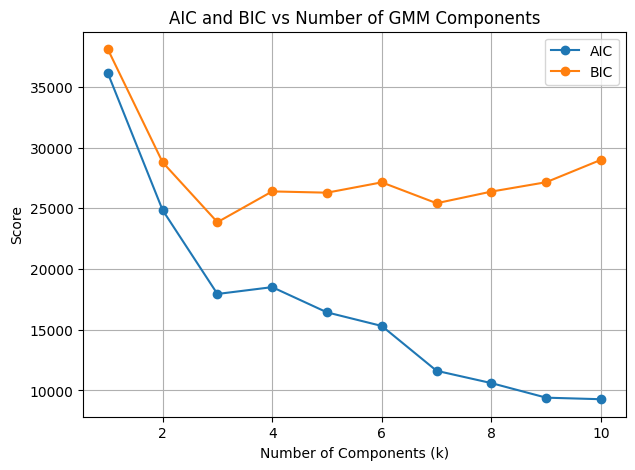

In [17]:
plt.figure(figsize=(7, 5))
plt.plot(k_range, aic_scores, marker='o', label='AIC')
plt.plot(k_range, bic_scores, marker='o', label='BIC')
plt.xlabel("Number of Components (k)")
plt.ylabel("Score")
plt.title("AIC and BIC vs Number of GMM Components")
plt.legend()
plt.grid(True)
plt.show()

For larger datasets, BIC penalizes model complexity more heavily than AIC.  
Also, BIC is often preferred in practice due to its Consistency and Scalability.

From the above graph , we can see that the lowest value of BIC is achieved at k = 3.
At this point, AIC also has a local minima.  
Therefore, we choose **optimal k = 3**

In [18]:
gmm1 = GaussianMixture(n_components = 3, n_init=10, random_state=42)
gmm1.fit(X_train_minority)

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


### 3. Data Generation

#### Process of Sampling from GMM

To generate synthetic samples, we exploit the probabilistic nature of the GMM:

1. Component selection – For each synthetic sample, we randomly select a Gaussian component based on the learned mixture weights (probabilities).

2. Sampling from Gaussian – Once a component is chosen, we draw a random vector from its multivariate normal distribution defined by the component’s mean and covariance.

3. Repeat – This process is repeated until the required number of synthetic samples is generated.

This approach ensures that synthetic samples are distributed across all high-density regions of the minority class, respecting cluster boundaries and avoiding the interpolation artifacts common in simpler methods like SMOTE.

In [19]:
n_minority = X_train_minority.shape[0]
n_majority = (y_train == 0).sum()
n_to_generate = n_majority - n_minority   # balance the dataset

# Generate synthetic samples in scaled space
X_synthetic, _ = gmm1.sample(n_to_generate)

# Create corresponding labels
y_synthetic = np.full(shape = n_to_generate, fill_value = 1)

# Combine with original training data
X_train_balanced = np.concatenate([X_train, X_synthetic] , axis = 0)
y_train_balanced = np.concatenate([y_train, y_synthetic] , axis = 0)

print("Original dataset shape:", X_train.shape, y_train.shape)
print("Balanced dataset shape:", X_train_balanced.shape, y_train_balanced.shape)

Original dataset shape: (227845, 30) (227845,)
Balanced dataset shape: (454902, 30) (454902,)


In [20]:
print (pd.Series(y_train_balanced).value_counts())

0    227451
1    227451
Name: count, dtype: int64


### 4. Rebalancing with CBU

#### Choosing a suitable population for the majority class

1. When imbalance is extreme ( higher than 1 : 100), GMMs are not desired because the large number of majority class samples can overwhelm the model, leading to biased parameter estimation and poor generalization on minority classes, resulting in low accuracy for those important classes. And, GMMs can struggle to accurately model complex, noisy, or overlapping distributions that often accompany severe imbalance, and existing resampling techniques may introduce their own issues with over- or under-sampling minority classes.
2. When imbalance is moderate ( around 1 : 10), then the GMM has enough minority data relative to the problem size to model real sub-clusters.
3. When imbalance is low ( < 1 : 5), Oversampling still works, but the value it adds to the dataset decreases. This may not improve the model much beyond SMOTE or even no resampling.

Therefore, since there are close to 400 minority samples in the training dataset ,  
We can **undersample the majority to 5000 samples** using CBU to get around **1:10 ratio**.

#### Applying CBU on the majority dataset

In [21]:
target_size = 5000
sampling_strategy = {0 : target_size}

cc = ClusterCentroids(estimator = MiniBatchKMeans(), sampling_strategy=sampling_strategy, random_state=42)


X_res, y_res = cc.fit_resample(X_train, y_train)

print("Original dataset shape:", X_train.shape, y_train.shape)
print("Resampled dataset shape:", X_res.shape, y_res.shape)

Original dataset shape: (227845, 30) (227845,)
Resampled dataset shape: (5394, 30) (5394,)


#### Apply GMM base Synthetic Sampling to match the new majority population

We can use the same optimal k used in the previous example since k depends only on the minority class dataset and we did not change the minority class dataset at all.

In [22]:
gmm = GaussianMixture(n_components = 3, n_init = 10, random_state = 42)
gmm.fit(X_train_minority)

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,10
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [23]:
n_majority = np.sum(y_res == 0)
n_minority = np.sum(y_res == 1)
n_to_generate = n_majority - n_minority   # balance

X_synth, _ = gmm.sample(n_to_generate)

# -------------------------------
# Step 4: Combine datasets
# -------------------------------
X_balanced = np.concatenate([X_res, X_synth])
y_balanced = np.concatenate([y_res, np.full(n_to_generate, 1)])

print("Balanced dataset shape:", X_balanced.shape, y_balanced.shape)
print("Final class counts:", 
      {0: np.sum(y_balanced == 0),
       1: np.sum(y_balanced == 1)})


Balanced dataset shape: (10000, 30) (10000,)
Final class counts: {0: np.int64(5000), 1: np.int64(5000)}


## Part C : Performance Evaluation and Conclusion

### 1.Model Training and Evaluation 

#### Version 1 ( without majority class undersampling)

In [24]:
model2 = LogisticRegression(max_iter = 200)
model2.fit(X_train_balanced, y_train_balanced)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


In [25]:
y_pred_gmm = model2.predict(X_test.values)

accuracy_gmm = accuracy_score(y_test, y_pred_gmm)
precision_gmm = precision_score(y_test, y_pred_gmm)
recall_gmm = recall_score(y_test, y_pred_gmm)
f1score_gmm = f1_score(y_test, y_pred_gmm)

print("Classification_report:\n")
print ("Accuracy:  ", accuracy_gmm)
print ("Precision:  ", precision_gmm)
print ("Recall:  ", recall_gmm)
print ("F1 score:  ", f1score_gmm)

Classification_report:

Accuracy:   0.9817773252343668
Precision:   0.07960644007155634
Recall:   0.9081632653061225
F1 score:   0.14638157894736842


In [26]:
print (confusion_matrix(y_test, y_pred_gmm))

[[55835  1029]
 [    9    89]]


#### Version 2 (with majority class undersampling)

In [27]:
model3 = LogisticRegression()
model3.fit(X_balanced, y_balanced)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [28]:
y_pred_cbu_gmm = model3.predict(X_test.values)

accuracy_cbu_gmm = accuracy_score(y_test, y_pred_cbu_gmm)
precision_cbu_gmm = precision_score(y_test, y_pred_cbu_gmm)
recall_cbu_gmm = recall_score(y_test, y_pred_cbu_gmm)
f1score_cbu_gmm = f1_score(y_test, y_pred_cbu_gmm)

print("Classification_report:\n")
print ("Accuracy:  ", accuracy_cbu_gmm)
print ("Precision:  ", precision_cbu_gmm)
print ("Recall:  ", recall_cbu_gmm)
print ("F1 score:  ", f1score_cbu_gmm)

Classification_report:

Accuracy:   0.9833748814999473
Precision:   0.08585365853658537
Recall:   0.8979591836734694
F1 score:   0.15672306322350846


In [29]:
print (confusion_matrix(y_test, y_pred_cbu_gmm))

[[55927   937]
 [   10    88]]


### 2.Comparative Analysis

In [33]:
metrics = {
    "Baseline" : [ precision_baseline, recall_baseline, f1score_baseline],
    "GMM" : [precision_gmm, recall_gmm, f1score_gmm],
    "CBU_GMM" : [precision_cbu_gmm, recall_cbu_gmm, f1score_cbu_gmm]
}

print (pd.DataFrame(metrics , index = ["Precision", "Recall", "F1 score"]).T)

          Precision    Recall  F1 score
Baseline   0.828947  0.642857  0.724138
GMM        0.079606  0.908163  0.146382
CBU_GMM    0.085854  0.897959  0.156723


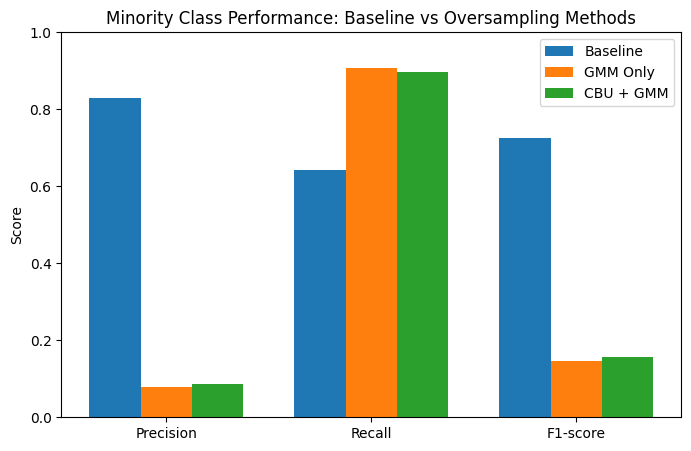

In [31]:
labels = ["Precision", "Recall", "F1-score"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width, metrics["Baseline"], width, label="Baseline")
ax.bar(x, metrics["GMM"], width, label="GMM Only")
ax.bar(x + width, metrics["CBU_GMM"], width, label="CBU + GMM")

ax.set_ylabel("Score")
ax.set_title("Minority Class Performance: Baseline vs Oversampling Methods")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.ylim(0,1)
plt.show()

- The baseline model achieves strong precision (0.83) and a balanced F1-score (0.72), but its recall is only 0.64, meaning that over one-third of minority class instances are missed.
-  In contrast, GMM-based oversampling raises recall to 0.91, ensuring that almost all minority cases are detected. However, this improvement comes with a high reduction in precision (0.08) and a much lower F1-score (0.15), reflecting a large number of false positives.
-   The CBU + GMM approach achieves almost the same recall (0.90) compared to GMM alone, but it improves precision to 0.09 and produces a higher F1-score (0.16).

While precision and overall F1-score decline under GMM-based oversampling, the recall rises to nearly 0.90, ensuring that almost all minority class instances are correctly detected. In highly imbalanced domains such as fraud detection, where missing a minority case is far costlier than producing false alarms, this improvement in recall is far more valuable than the loss in precision.

### 3.Final Recommendation

Based on the analysis, **GMM-based oversampling is the preferred strategy** when recall is the most critical metric. Both GMM and CBU + GMM achieve recall close to 0.90, much higher baseline recall of 0.64. Although this gain comes with a reduction in precision (≈0.08) and a lower F1-score, the ability to capture nearly all minority cases is far more important in contexts such as fraud detection or medical diagnosis, where missing a positive case carries a high cost.

The baseline model, despite its higher precision (0.83), misses a significant fraction of minority cases and is therefore less effective in cases where recall is priorotised. **Between the two GMM-based approaches, the results are nearly identical**, suggesting that GMM oversampling alone is sufficient, and additional undersampling via CBU does not provide a meaningful advantage in this dataset.

**Recommendation**: In recall-critical applications, GMM-based oversampling should be adopted, as it maximizes the detection of minority class instances, even at the expense of increased false positives.